## James Griffin 
### Elementary Educaiton Analysis 
### Stat 536 Dr Heaton

Elementary Education
As described by the US news and world report, ``the elementary years – from kindergarten through third grade – are particularly important ones in children’s schooling. Parents and teachers know that children acquire new skills and knowledge rapidly during these years. Research shows that average annual learning gains for children in grades K-2 are dramatically greater than those for subsequent years of school. Moreover, the outcomes of early elementary education, particularly whether or not a child can read proficiently by third grade, are a powerful predictor of later school and life outcomes.’’

Due to the importance of elementary education, in this analysis you will be looking at how various factors affect learning in elementary school as measured by results on a standardized test. The SchoolResults.txt data contain information on various school districts throughout California and includes the following variables:

Variable Name  - 	Description
* Score - Average cumulative Score on the Stanford 9 standardized test (out of 1600)
* Lunch - Percent qualifying for reduced-price lunch
* Computer - Number of Computers
* Expenditure -	Expenditure per student
* Income - District average income (in USD 1,000)
* English - Percent of English learners
* STratio -	Student-to-teacher ratio


In your analysis, make sure you answer the following questions:

1. “Income” is generally a measure of how much money a school has to spend on extracurricular activities (as opposed to expenditures which is how much spent per student in the class room). Is there evidence of diminishing returns on extracurricular activities in terms of student learning?
2. Is english as a second language a barrier to student learning?
3. In your opinion and based on the data, what can be done to increase student learning?

In [39]:

def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""
    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)
    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0
    minxd = np.min(xd)
    maxxd = np.max(xd)
    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept
    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha)
    #Calculate R Squared
    p = np.poly1d(coeffs)
    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot
    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr

In [44]:
#importing a bunch of stuff that I may use 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import seaborn as sns
from scipy import stats
import warnings; warnings.simplefilter('ignore')

In [54]:
data = pd.read_csv("../data/el_ed.txt", sep=" ")
data.head()

,Score,Lunch,Computer,Expenditure,Income,English,STratio
0,1372.62,2.04,67,6384.91,22.69,0.00,17.89
1,1316.21,47.92,101,5099.38,9.82,4.58,21.52
2,1291.41,76.32,169,5501.95,8.98,30.00,18.70
3,1288.42,77.05,85,7101.83,8.98,0.00,17.36
4,1242.14,78.43,171,5235.99,9.08,13.86,18.67


##### #1  Is there evidence of diminishing returns on extracurricular activities in terms of student learning?


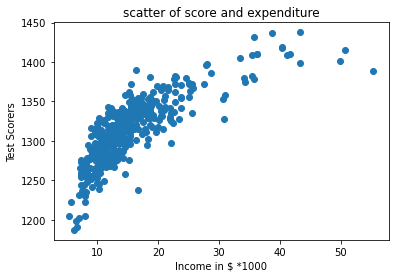

In [55]:
plt.scatter(x = data.Income, y = data.Score)
plt.title("scatter of score and expenditure")
plt.xlabel('Income in $ *1000')
plt.ylabel("Test Scorers")
plt.show()

Ok so there does appear to be a dimitionshing marginal return on income when it relates to test scores, we can understand this better if we break this up into segments of like $10 dollars 

In [56]:
#creating new features for exploring this problem more 
#creating income data frame
i_df = pd.DataFrame()
i_df['0_10'] = data.Income.apply(lambda x: 1 if x<=10 else 0)
i_df['10_19'] = data.Income.apply(lambda x: 1 if 10<x<=20 else 0)
i_df['20_29'] = data.Income.apply(lambda x: 1 if 20<x<=29 else 0)
i_df['30_39'] = data.Income.apply(lambda x: 1 if 30<x<=39 else 0)
#i_df['40+'] = data.Income.apply(lambda x: 1 if 39<x else 0)

In [60]:
#So now having bined the continuous variables, we can see what the returns are for each group of observation 
#if we run a little linear regression 
y = data.Score
reg_obj = sm.OLS(y ,i_df)

results = reg_obj.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              4041.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):                        0.00
Time:                        21:25:09   Log-Likelihood:                         -2838.1
No. Observations:                 420   AIC:                                      5684.
Df Residuals:                     416   BIC:                                      5700.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [58]:
df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]
for i in range(len(df)-1):
    a=df['coef'].values[i]
    b=df['coef'].values[i+1]
    c = np.absolute(a-b)
    print(c)
    

47.60770000000002
40.394000000000005
35.668300000000045


Ok awesome, so we can see that there are different levels of return for the different amounts of spending that happens on extra cirricular activities. As one would expect, there is a high return to the initial amount of money spent, that for essentially if you are spending within the (0,10) bin that you are getting 1265 point on the exam on average for those dollars spent. 

Now for understanding the following coefficients, this is slightly harder to inturpret because if you are spending 10-20, you are also spending (0,10). So the second group is getting the benefit of the dollars that the first group gets, plus the extra benefit for the second group. that is why to see if there is a dimionshing marginal return, we cannot simply take the coefficient, we must subtract the initial coef from the 0-10 group, doing this we get that the marginal difference of 10-19 dollars per student mosnt 1,313 on the exam, but rahter it is 1313-1265 = 48, for the next group it is 40, and the next it is 36. So yes, we can conclude that there are diminoshing marginal returns for income related to test scores

In [52]:
data['log_income'] = np.log(data.Income)
li_df = pd.DataFrame()
li_df['0_10'] = data.log_income.apply(lambda x: 1 if x<=np.log(10) else 0)
li_df['10_19'] = data.log_income.apply(lambda x: 1 if np.log(10)<x<=np.log(20) else 0)
li_df['20_29'] = data.log_income.apply(lambda x: 1 if np.log(20)<x<=np.log(29) else 0)
li_df['30_39'] = data.log_income.apply(lambda x: 1 if np.log(30)<x<=np.log(39) else 0)


y = data.Score
reg_obj = sm.OLS(y ,li_df)

results = reg_obj.fit()
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              4041.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):                        0.00
Time:                        21:12:18   Log-Likelihood:                         -2838.1
No. Observations:                 420   AIC:                                      5684.
Df Residuals:                     416   BIC:                                      5700.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

2. Is english as a second language a barrier to student learning?

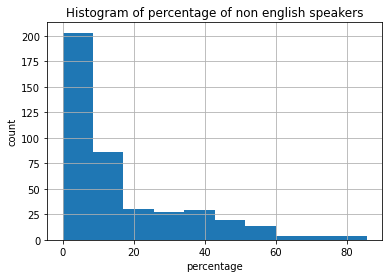

In [8]:
#ok lets look at this 
data.English.hist()
plt.title("Histogram of percentage of non english speakers")
plt.xlabel("percentage")
plt.ylabel("count")
plt.show()

So in this, our data is really skewed, and we know that the tail region may act as an outlier for the statistical models and we know that outliers adversely affect the model’s performance especially regression-based models. However traditionally, I just take the log of thigs like this, but we can't because there are lotts of zeros, which would give us negattive infinity in that transform, which is hard for statistical models to inturpret 

I think ther are a couple of things that we can do, we can bin them, similar to what we did above, and then take their effects but also find their mean scores of testing 

I should also investigate if having a large percentage of immigrnats / non english speakers corelates with reduced price lunch, income and expenditure. Seeing as public schools at least in the US are funded by tax prayers in that school area, if there is a lower income demographic, then we would have lots of coliniarity here, so we need to look at our independencies first I think

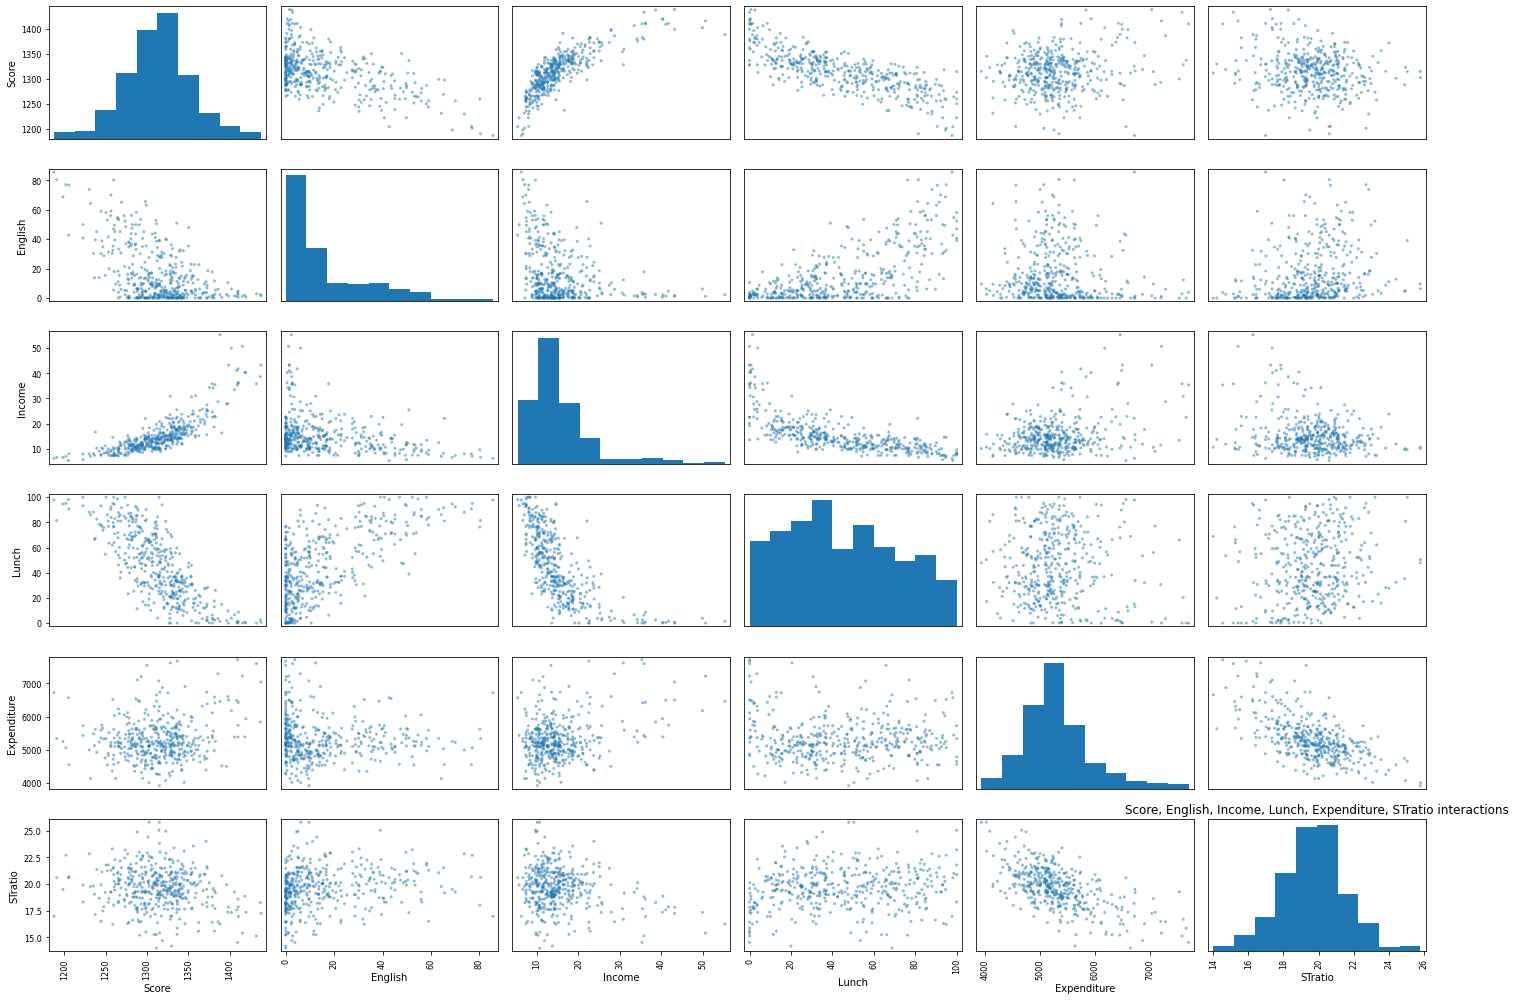

In [105]:
scatter = data[["Score", "English", "Income",
                  "Lunch", "Expenditure",'STratio']]

scatter_matrix(scatter, alpha = .5, figsize= [20, 14])
plt.title("Score, English, Income, Lunch, Expenditure, STratio interactions")
scatter_matrix
plt.tight_layout()
plt.show()

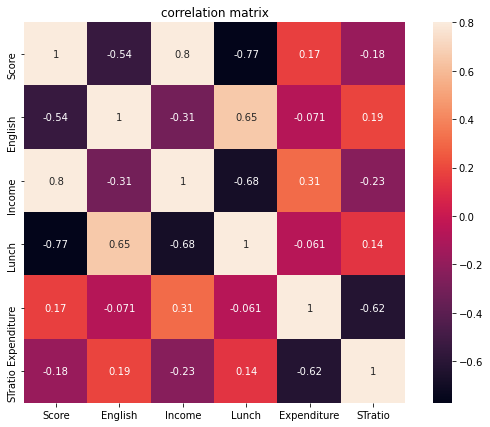

In [63]:
#lets visualize this one more way 
corr_mat = scatter.corr()
f, ax = plt.subplots(figsize = (10,7))
sns.heatmap(corr_mat,vmax=.8,square=True, annot = True)
plt.title("correlation matrix")
plt.show()

yeah so that is kind of what I thought, there are lots of correlations here that are sizeable, english with score, score with lunch, english with lunch, lunch with income, income with englihs even, 

In [11]:
#Ok so if we are addressing what effect does english have on test scores, we will need to 
#create some sort of interaction term with lunch because the two are colinear with score
data['eng_lun'] = data.Lunch * data.English


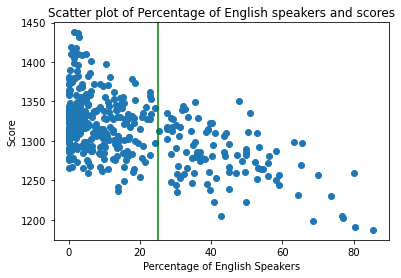

In [21]:

xv1 = 25
plt.scatter(x = data.English, y= data.Score)
plt.axvline(xv1, color = 'green')
plt.title("Scatter plot of Percentage of English speakers and scores")
plt.xlabel('Percentage of English Speakers')
plt.ylabel("Score")
plt.show()

In [74]:
### ok so there is a rahter natural break in the data at about 25% non english speakers, 
## gonna plit the data and do a difference of means test 
data['eng>25'] = data.English.apply(lambda x: 1 if x >= 25 else 0 )
high_e = data.loc[data['eng>25'] == 0]
low_e = data.loc[data['eng>25'] == 1]

In [14]:
stats.ttest_ind(high_e.Score, low_e.Score, equal_var = False)

Ttest_indResult(statistic=10.584205111956907, pvalue=2.4199661003700006e-20)

In [66]:
# Load libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x3 = data[['English', 'Income', "Lunch"]]

# Create interaction term (not polynomial features)
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(x3)



In [77]:
data['eng>25']

data['eng25*luch'] = data['eng>25']*data['Lunch']
data['eng25*income'] = data['eng>25']*data['Income']

x4 = data[['eng>25', 'eng25*luch', 'eng25*income']]

In [80]:
x5 = i_df.copy()
x5['eng'] = data.English
x5['lunch'] = data.Lunch

yi = 0 + 0.5xi1 + ( 0.5)xi2 + ( 1)xi1xi2 +✏i

In [100]:
x6 = x3.copy()
x6['English'] = -0.5*x3.English
x6['Lunch'] = -0.5*x3.Lunch
x6['eng*lunch'] = (x3.English*x3.Lunch)
x6.columns

Index(['English', 'Income', 'Lunch', 'eng*lunch'], dtype='object')

In [101]:
#ok so we can reject the null hypothesis and say that these two populations do indeed have different 
#testing scores 

reg_obj = sm.OLS(y, x6)

results = reg_obj.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Score   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              2982.
Date:                Wed, 24 Feb 2021   Prob (F-statistic):                   1.14e-304
Time:                        10:56:54   Log-Likelihood:                         -2900.1
No. Observations:                 420   AIC:                                      5808.
Df Residuals:                     416   BIC:                                      5824.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

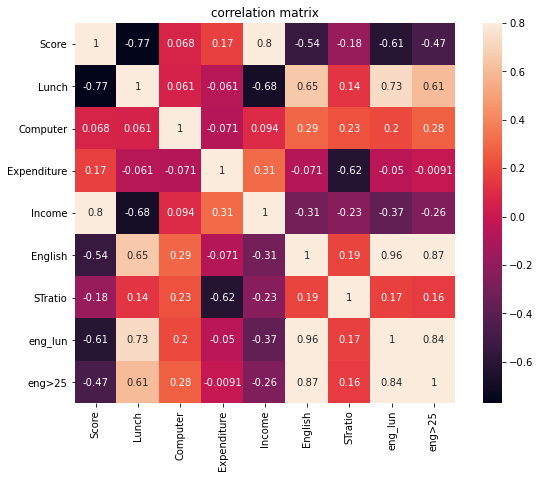

In [16]:
#lets visualize this one more way 
corr_mat = data.corr()
f, ax = plt.subplots(figsize = (10,7))
sns.heatmap(corr_mat,vmax=.8,square=True, annot = True)
plt.title("correlation matrix")
plt.show()

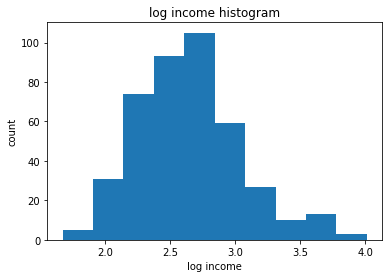

In [28]:
li = np.log(data.Income)
plt.hist(li)
plt.title("log income histogram")
plt.xlabel('log income')
plt.ylabel('count')
plt.show()

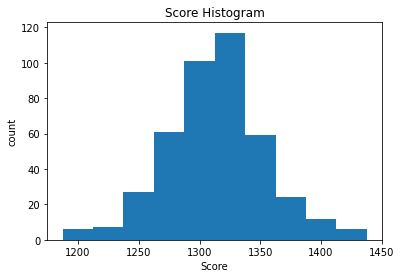

In [27]:

plt.hist(data.Score)
plt.title("Score Histogram")
plt.xlabel("Score")
plt.ylabel("count")
plt.show()

In [143]:
def lasso_cols(y, scaled_df, alpha_level, cat_df):
    '''
    Parameters:
    y = target variable, 
    scaled_df = a scaled data frame from above
    alpha_level = learning rate for peanlizing the regression - a hyper parameter we can tune to ensure that 
    we are not over fitting
    cat_df = a category of the data that we are looking at, human, climate, network etc. 
    ''' 
    from sklearn.model_selection import RepeatedKFold
    from sklearn.linear_model import LassoCV
    from sklearn.metrics import mean_absolute_error
    #split into train and testing
    X_train, X_test, y_train, y_test = train_test_split(scaled_df, 
                                                    y, 
                                                    random_state=42)
    
    #ok now cross validating 
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

    #fit model
    model.fit(X_train, y_train)
    #display lambda that produced the lowest test MSE
    print(model.alpha_)

    lasso_cv1 = Lasso(alpha=alpha_level, max_iter=1000, normalize = True).fit(X_train, y_train)
    #five fold cross validation 
    scores = cross_val_score(lasso_cv1, X_train, y_train, cv=5)
    
    t = lasso_cv1.predict(X_test)
    
    mae_rf = mean_absolute_error(t, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(t, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = t, y = y_test, color = "blue")
    plt.title("RF regression")
    plt.ylabel('True Metric')
    plt.xlabel("Predicted Metric")
    trendline(t, y_test)
    plt.show()
    
    
    print("Cross-validation scores: {}".format(scores))
    print("Average cross-validation score: {:.2f}".format(scores.mean()))
    #to know if we are chosing the right alpha, we need tot look at our test and training scores 
    #and this will give us our test score, to see if we are over fitting 
    print("Test set score alpha = " +str(alpha_level)+" : {:.2f}".format(lasso_cv1.score(X_test, y_test)))
    print("Number of features used:", np.sum(lasso_cv1.coef_ != 0))
    new_df = pd.DataFrame()
    la_coef = list(lasso_cv1.coef_)
    cols = list(scaled_df.columns)
    new_df['cols'] = cols
    new_df['scores'] = la_coef
    non_0 = new_df.loc[new_df.scores != 0 ]
    
    #lasso_cv1.pred_num
    '''    
    lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
    l_num = 7
    pred_num = scaled_df.shape[1]

    # prepare data for enumerate
    coeff_a = np.zeros((l_num, pred_num))
    train_r_squared = np.zeros(l_num)
    test_r_squared = np.zeros(l_num)


    # enumerate through lambdas with index and i
    for ind, i in enumerate(lambdas):    
        reg = Lasso(alpha= i, max_iter=1000, normalize = True).fit(X_train, y_train)

        coeff_a[ind,:] = reg.coef_
        train_r_squared[ind] = reg.score(X_train, y_train)
        test_r_squared[ind] = reg.score(X_test, y_test)'''

    # Plotting
    resid = t - y_test
    plt.hist(resid)
    plt.title("residual graph")
    plt.show()

    
    
    return non_0, t

0.99
mean_absolute_error
17.546569504766705
 
root_mean_squarered_error
21.603333657933174


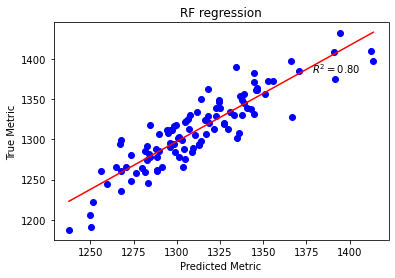

Cross-validation scores: [0.78616074 0.72153388 0.77559783 0.71409751 0.65053221]
Average cross-validation score: 0.73
Test set score alpha = 0.05 : 0.78
Number of features used: 5


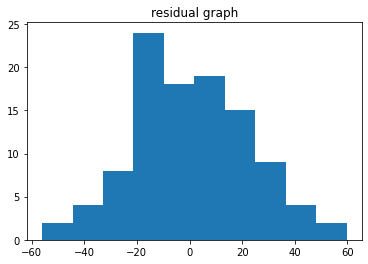

(         cols    scores
 0       Lunch -0.369365
 1    Computer  0.006777
 3      Income  2.842051
 4     English -0.378644
 7  eng25*luch -0.036602,
 array([1301.12702935, 1298.69265786, 1307.15183217, 1344.60529029,
        1412.38345559, 1283.19733233, 1298.59407654, 1313.99261886,
        1250.34469481, 1284.13067272, 1281.63646531, 1299.51589581,
        1340.39794815, 1307.67906838, 1337.84927104, 1413.7397131 ,
        1273.5391198 , 1309.29176061, 1302.7075327 , 1298.45372632,
        1313.72181523, 1309.01208968, 1346.22001663, 1322.95645648,
        1305.2509869 , 1344.56514671, 1288.72582376, 1352.70107576,
        1306.4877815 , 1296.33033351, 1337.46398593, 1279.93304516,
        1316.38751623, 1312.75500069, 1303.47888612, 1296.51918578,
        1327.41999516, 1264.97699505, 1312.80341763, 1338.90270178,
        1294.18354261, 1318.68565082, 1370.602066  , 1282.50537016,
        1289.79708919, 1350.90983728, 1282.5595826 , 1324.18666232,
        1334.6557487 , 1255.96765

In [144]:
X = data.drop(columns = ['Score'])
lasso_cols(data.Score, X, .05, "all")

In [122]:
x6 = data.loc[data['eng>25'] ==1]
np.mean(x6.English)
x7 = data.loc[data['eng>25'] ==0]
np.mean(x6.English)
xbar1 = (np.mean(x6.English) - 
        np.mean(x7.English))+(10.584205111956907 * 
                              ((np.std(x6.English)/len(x6)) - (np.std(x7.English)/len(x7)))**(1/2))

xbar2 = (np.mean(x6.English) - 
        np.mean(x7.English))-(10.584205111956907 * 
                              ((np.std(x6.English)/len(x6)) - (np.std(x7.English)/len(x7)))**(1/2))

In [118]:
np.mean(x6.English)

13.792034583578774

In [123]:
xbar1

40.766995141204035

In [124]:
xbar2

33.606445480327565

In [130]:
(np.mean(x6.English) - 
        np.mean(x7.English)) -10*(np.std(x6.English)/len(x6)) - (np.std(x7.English)/len(x7))**(1/2)

35.69036484340179

In [145]:
#============================================================================================================
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def train_predict(df):
    target = df["Score"]
    #target = norm['total compensation']
    X = df.drop(columns = ['Score'])
    #splitting into train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, 
                                                    random_state=17)

    #xclass = xgb.XGBRegressor(booster = 'dart')
    rf2 = RandomForestRegressor()

    parameters = {
        #'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'min_samples_split': [2,4,6,8],
        'max_depth': [25, 30, 35, 37, 40, 45, 50], #np.arange(1, 100, 1), #
        #'min_child_samples': [1, 3, 5], #np.arange(1, 15, 2), #,
        'min_samples_leaf': [1, 2, 3],
        #'subsample': np.arange(.3, .7, .1),
        #'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[700, 800, 900, 1000, 1100, 1200], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }
 
    #gs = RandomizedSearchCV(xclass, parameters, cv = 5
    #gs.fit(X_train, y_train)
    
    gs2 = RandomizedSearchCV(rf2, parameters, cv = 5)
    gs2.fit(X_train, y_train)
    
    #adjusting back from the log that we took 
    rf_pred2 = gs2.predict(X_test)

    mae_rf = mean_absolute_error(rf_pred2, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(rf_pred2, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = rf_pred2, y = y_test, color = "blue")
    plt.title("Random Forest CV = 5, base salary excluded")
    plt.xlabel('True resale_value')
    plt.ylabel("Predicted resale_value")
    trendline(rf_pred2, y_test)
    plt.show()
    
    #looking at how we did 
    #boost_preds = gs.predict(X_val)

    #mae_xgb = mean_absolute_error(np.e**(boost_preds), np.e**(y_val))
    #mse_xgb = mean_squared_error(np.e**(boost_preds), np.e**(y_val))
    #print("overall MAE")
    #print(mae_xgb)  
    #print(" ")
    #print(mse_xgb)

    #plt.scatter(x = rf_pred2, y = np.e**y_val, color = "blue")
    #plt.scatter(x = np.e**(y_val), y = np.e**(boost_preds), color = "lightgreen")
    #plt.title("xgboost CV = 5")
    #plt.xlabel('resale_value')
    #plt.ylabel("predicted_resale_value")
    #trendline(np.e**(boost_preds), np.e**(y_val))
    #plt.show()

    #X_val['predicted'] = boost_preds
    #X_val['actual'] = y_val
    
    y = np.sort(gs2.best_estimator_.feature_importances_)[::-1]
    x = X.columns[np.argsort(gs2.best_estimator_.feature_importances_)[::-1]]
    plt.barh(x[:10],y[:10])
    plt.tight_layout()
    plt.xlabel('Feature importance on testing')
    plt.ylabel('Feature name')
    plt.title('Feature importances in Prediction of Score from Random Forest')
    plt.show() 
    
    return gs2, mse_rf, mae_rf

mean_absolute_error
16.410571000642214
 
root_mean_squarered_error
20.626817709250098


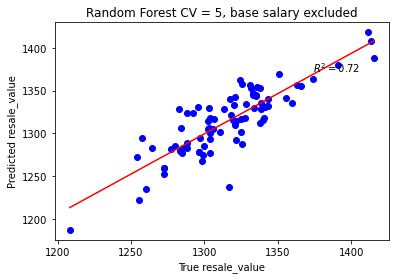

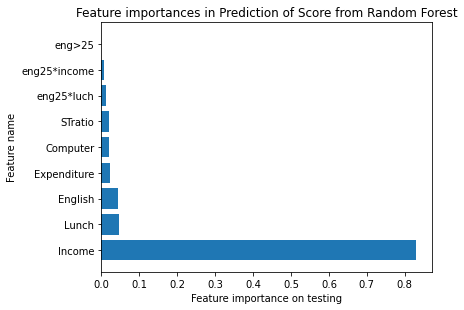

(RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                    param_distributions={'max_depth': [25, 30, 35, 37, 40, 45,
                                                       50],
                                         'min_samples_leaf': [1, 2, 3],
                                         'min_samples_split': [2, 4, 6, 8],
                                         'n_estimators': [700, 800, 900, 1000,
                                                          1100, 1200]}),
 20.626817709250098,
 16.410571000642214)

In [146]:
train_predict(data)